 # Notebook 3: Temporal Features Engineering

 ## Purpose
 - Extract comprehensive temporal features
 - Calculate rolling bias trends (7d, 30d, 90d windows)
 - Analyze publication time patterns
 - Detect seasonality in bias patterns
 - Create time-based aggregations

 ## Inputs
 - `data/processed/articles_with_events.csv`

 ## Outputs
 - `data/processed/temporal_features.parquet`

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported")

Libraries imported


In [19]:
# Paths
BASE_DIR = Path('..')
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'

INPUT_FILE = PROCESSED_DIR / 'articles_with_events.csv'
OUTPUT_FILE = PROCESSED_DIR / 'temporal_features.parquet'

 ## 1. Load Data

In [20]:
print("Loading integrated dataset...")
df = pd.read_csv(INPUT_FILE, parse_dates=['published_date_parsed', 'publication_date'])
print(f"Loaded {len(df):,} articles")

Loading integrated dataset...
Loaded 49,926 articles


/var/folders/9s/6vlynz8d6hzbq58p0sbxfjc174vfgt/T/ipykernel_16594/1271138022.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE, parse_dates=['published_date_parsed', 'publication_date'])


In [21]:
df.head(2)

,url,title,author,published_date,published_date_parsed,publication_date,publication_year,publication_month,publication_day,modified_date,section,tags,article_text,article_text_cleaned,word_count,word_count_calc,cleaned_word_count,media_name,scrape_date,merge_date,Date,Day,Is_Holiday,Holiday_Name,Holiday_Category,Events_Count,Event_Good_Count,Event_Bad_Count,Event_Sentiment,Event_Texts,Event_Links,day_of_week,day_name,is_weekend,hour_of_day,is_business_hours,week_of_year,quarter,days_to_nearest_holiday,days_to_next_holiday,days_from_previous_holiday,is_holiday_week,event_good_bad_ratio,event_sentiment_score,has_concurrent_events,daily_article_count,rolling_7d_avg,rolling_30d_avg
0,https://indianexpress.com/article/technology/m...,Amazon Great Indian Festival sale: Top deals o...,":Tech DeskNew Delhi |Updated: October 8, 2018 ...",2018-10-08,2018-10-08,2018-10-08,2018.0,10.0,8.0,2018-10-08T22:27:48+05:30,General,NaN,Amazon Great Indian Festival sale:Amazon’s upc...,amazon great festival sale amazon upcoming gre...,896,884,490,THE INDIAN EXPRESS,2018-10-08,2018-10-08,2018-10-08,Monday,0,NaN,NaN,0,0,0,neutral,NaN,NaN,0,Monday,0,0,0,41,4,6,11,6,1,0.0,0,0,6,4.857143,4.533333
1,https://indianexpress.com/article/news-archive...,Cong’s wasteland,"PRANNOY ROY, YOGENDRA YADAV, I P BAJPAI, NAMRA...",2004-03-28,2004-03-28,2004-03-28,2004.0,3.0,28.0,2004-03-28,General,NaN,"A mid-March opinion poll, jointly commissioned...",mid march opinion poll jointly commissioned by...,1067,1049,532,THE INDIAN EXPRESS,2004-03-28,2004-03-28,2004-03-28,Sunday,0,NaN,NaN,0,0,0,neutral,NaN,NaN,6,Sunday,1,0,0,13,1,6,6,26,1,0.0,0,0,7,5.428571,4.766667


 ## 2. Time-Based Feature Engineering

In [22]:
print("Creating advanced temporal features...")

# Day of month
df['day_of_month'] = pd.to_datetime(df['publication_date']).dt.day

# Is month start/end
df['is_month_start'] = (df['day_of_month'] <= 7).astype(int)
df['is_month_end'] = (df['day_of_month'] >= 24).astype(int)

# Is quarter start/end
df['is_quarter_start'] = df['publication_month'].isin([1, 4, 7, 10]).astype(int)
df['is_quarter_end'] = df['publication_month'].isin([3, 6, 9, 12]).astype(int)

# Season (for India: Summer, Monsoon, Winter)


def get_indian_season(month):
    if month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 7, 8, 9]:
        return 'monsoon'
    else:
        return 'winter'


df['season'] = df['publication_month'].apply(get_indian_season)

# Days since year start
df['day_of_year'] = pd.to_datetime(df['publication_date']).dt.dayofyear

print("Advanced temporal features created")

Creating advanced temporal features...
Advanced temporal features created


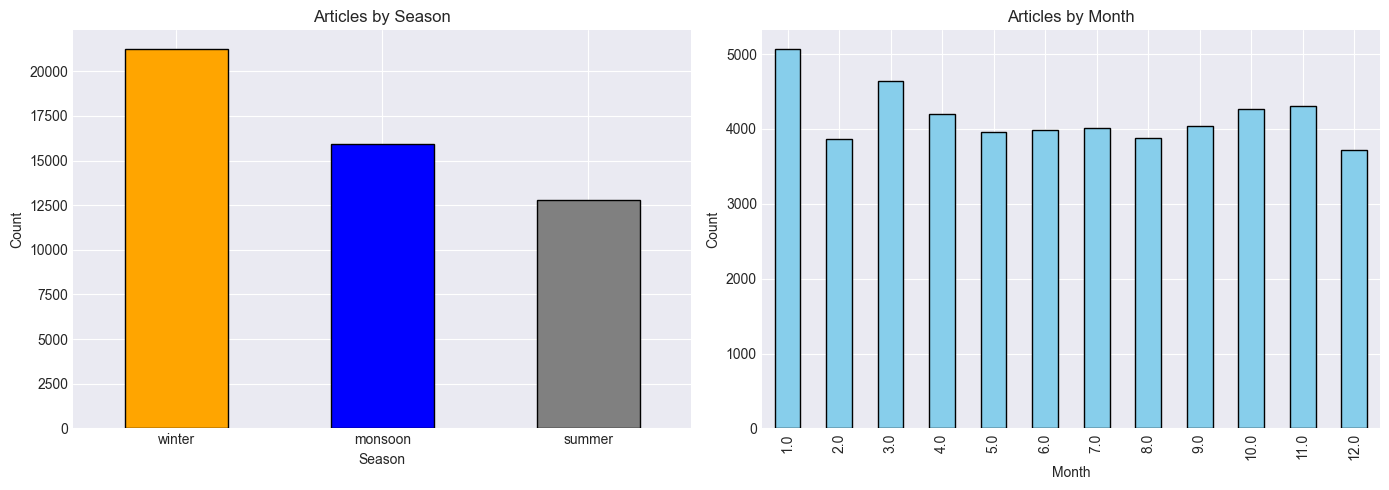

In [23]:
# Visualize seasonal distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

season_counts = df['season'].value_counts()
season_counts.plot(kind='bar', ax=axes[0], color=['orange', 'blue', 'gray'], edgecolor='black')
axes[0].set_title('Articles by Season')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

month_counts = df['publication_month'].value_counts().sort_index()
month_counts.plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Articles by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

#### Key Insights: Seasonal and Monthly Article Distribution

1) Winter has the highest article volume, followed by monsoon, with summer having the fewest articles, indicating a clear seasonal skew toward winter/monsoon coverage.

2) Monthly publishing is fairly even but peaks in January, with only mild dips in some mid‑year and year‑end months, suggesting no extreme month‑to‑month fluctuations beyond this early‑year spike.

 ## 3. Publication Velocity Features

In [24]:
print("Calculating publication velocity...")

# Sort by date
df_sorted = df.sort_values('publication_date')

# Articles per day
daily_stats = df_sorted.groupby('publication_date').agg({
    'url': 'count',
    'word_count_calc': ['mean', 'median', 'sum']
}).reset_index()

daily_stats.columns = ['publication_date', 'articles_per_day',
                       'avg_words_per_article', 'median_words', 'total_words_per_day']

# Rolling statistics
daily_stats['rolling_7d_article_count'] = daily_stats['articles_per_day'].rolling(window=7, min_periods=1).mean()
daily_stats['rolling_30d_article_count'] = daily_stats['articles_per_day'].rolling(window=30, min_periods=1).mean()
daily_stats['rolling_90d_article_count'] = daily_stats['articles_per_day'].rolling(window=90, min_periods=1).mean()

# Velocity (rate of change)
daily_stats['velocity_7d'] = daily_stats['rolling_7d_article_count'].diff()
daily_stats['velocity_30d'] = daily_stats['rolling_30d_article_count'].diff()

# Merge back
df = df.merge(daily_stats, on='publication_date', how='left')

print("Publication velocity features created")

Calculating publication velocity...
Publication velocity features created


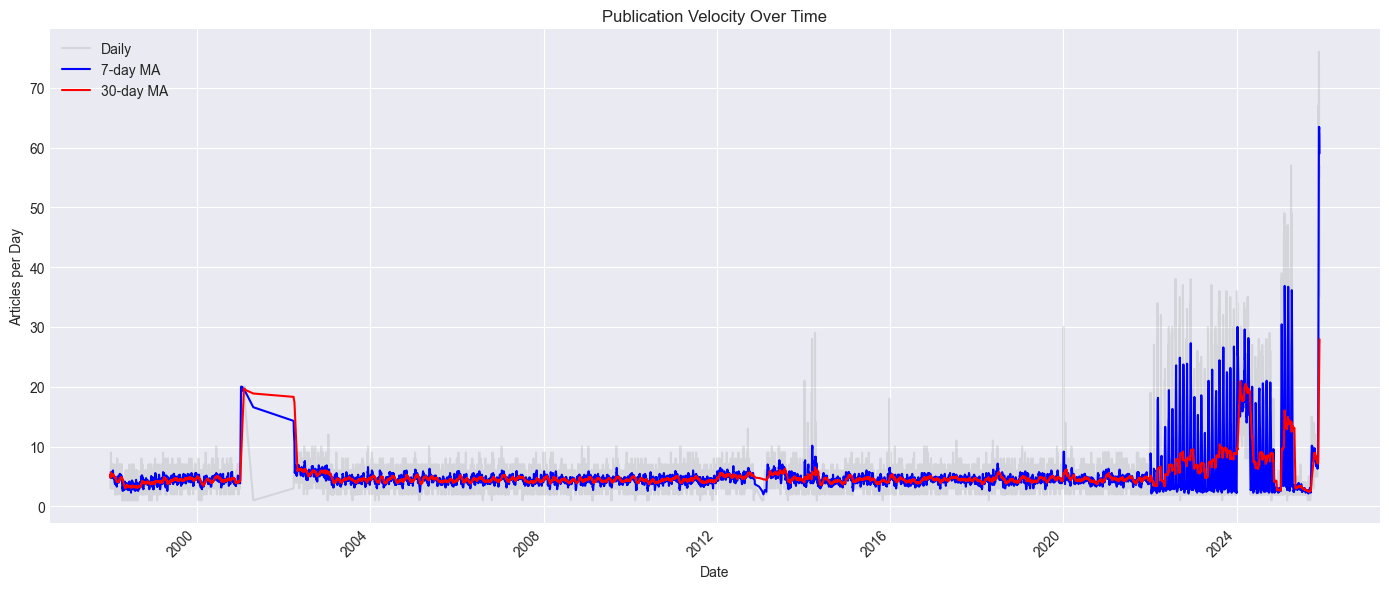

In [25]:
# Visualize publication velocity
fig, ax = plt.subplots(figsize=(14, 6))
daily_stats.plot(x='publication_date', y='articles_per_day', ax=ax, alpha=0.2, label='Daily', color='gray')
daily_stats.plot(x='publication_date', y='rolling_7d_article_count', ax=ax, label='7-day MA', color='blue')
daily_stats.plot(x='publication_date', y='rolling_30d_article_count', ax=ax, label='30-day MA', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Articles per Day')
ax.set_title('Publication Velocity Over Time')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Key Insights: Publication Velocity Over Time

1) Long-term publishing was mostly low and stable, with around 4–6 articles per day and only a brief early spike, as reflected by relatively flat 7‑day and 30‑day moving averages for most of the timeline.

2) Recent years show a sharp acceleration and higher volatility, with frequent spikes above 20–30 articles per day and 7‑day averages rising well above the 30‑day trend, indicating more intense and bursty publishing activity.

 ## 4. Time-Since Features

In [26]:
print("Calculating time-since features...")

# Time since first article
first_date = df['publication_date'].min()
df['days_since_first_article'] = (pd.to_datetime(df['publication_date']) - first_date).dt.days

# Time since last major event (if events exist)
if 'Events_Count' in df.columns:
    # Get dates with significant events (>= 3 events)
    major_event_dates = pd.to_datetime(df[df['Events_Count'] >= 3]['publication_date'].unique())

    def days_since_major_event(date):
        date = pd.to_datetime(date)
        valid_past_events = [d for d in major_event_dates if d <= date]
        if len(valid_past_events) > 0:
            return (date - max(valid_past_events)).days
        return None

    df['days_since_major_event'] = df['publication_date'].apply(days_since_major_event)
else:
    df['days_since_major_event'] = None

print("Time-since features created")

Calculating time-since features...
Time-since features created


 ## 5. Cyclical Features (Sine/Cosine Encoding)

In [27]:
print("Creating cyclical encodings...")

# Encode day of week (0-6) as circular
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Encode month (1-12) as circular
df['month_sin'] = np.sin(2 * np.pi * (df['publication_month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['publication_month'] - 1) / 12)

# Encode hour (0-23) as circular
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

# Encode day of year (1-365) as circular
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

print("Cyclical encodings created")

Creating cyclical encodings...
Cyclical encodings created


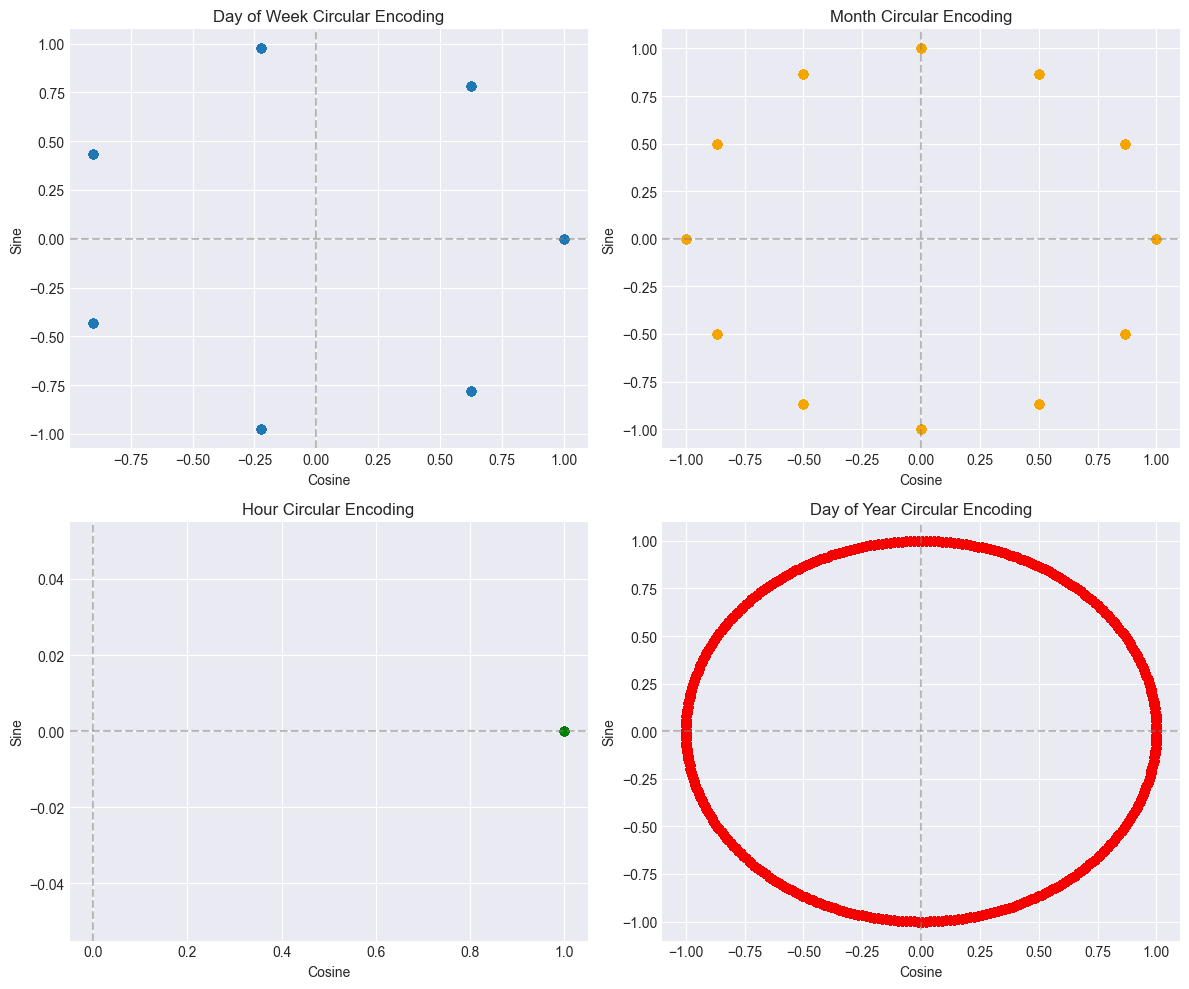

In [28]:
# Visualize cyclical encoding
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Day of week
axes[0, 0].scatter(df['day_of_week_cos'], df['day_of_week_sin'], alpha=0.1)
axes[0, 0].set_xlabel('Cosine')
axes[0, 0].set_ylabel('Sine')
axes[0, 0].set_title('Day of Week Circular Encoding')
axes[0, 0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].axvline(0, color='gray', linestyle='--', alpha=0.5)

# Month
axes[0, 1].scatter(df['month_cos'], df['month_sin'], alpha=0.1, color='orange')
axes[0, 1].set_xlabel('Cosine')
axes[0, 1].set_ylabel('Sine')
axes[0, 1].set_title('Month Circular Encoding')
axes[0, 1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].axvline(0, color='gray', linestyle='--', alpha=0.5)

# Hour
axes[1, 0].scatter(df['hour_cos'], df['hour_sin'], alpha=0.1, color='green')
axes[1, 0].set_xlabel('Cosine')
axes[1, 0].set_ylabel('Sine')
axes[1, 0].set_title('Hour Circular Encoding')
axes[1, 0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].axvline(0, color='gray', linestyle='--', alpha=0.5)

# Day of year
axes[1, 1].scatter(df['day_of_year_cos'], df['day_of_year_sin'], alpha=0.1, color='red')
axes[1, 1].set_xlabel('Cosine')
axes[1, 1].set_ylabel('Sine')
axes[1, 1].set_title('Day of Year Circular Encoding')
axes[1, 1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[1, 1].axvline(0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Key Insights: Circular Time Encodings

1) Time fields are mapped onto a circle using sine/cosine pairs, so days of week, months, hours, and days of year are all represented as points around a unit circle. This preserves their cyclical nature (e.g., Sunday is close to Monday, December is close to January).

2) Granularity differs by feature:
- Day-of-week and month show a few discrete points.
- Hour has only one visible point (the data concentrates in a single hour).
- Day-of-year forms a full ring, showing all 365 positions, capturing fine‑grained seasonality.


 ## 6. Temporal Patterns & Anomalies

In [29]:
print("Detecting temporal patterns...")

# Publication count z-score (anomaly detection)
df['publication_count_zscore'] = stats.zscore(df['articles_per_day'])

# Flag unusual days (> 2 std deviations)
df['is_unusual_volume_day'] = (np.abs(df['publication_count_zscore']) > 2).astype(int)

# Publication consistency (coefficient of variation over rolling window)
daily_stats['publication_volatility_30d'] = (
    daily_stats['articles_per_day'].rolling(window=30, min_periods=1).std()
    / daily_stats['articles_per_day'].rolling(window=30, min_periods=1).mean()
)

df = df.merge(daily_stats[['publication_date', 'publication_volatility_30d']],
              on='publication_date', how='left')

print("Temporal patterns detected")

Detecting temporal patterns...
Temporal patterns detected


In [30]:
# Identify unusual days
unusual_days = df[df['is_unusual_volume_day'] == 1][['publication_date', 'articles_per_day']].drop_duplicates()
print(f"\nUnusual volume days detected: {len(unusual_days)}")
if len(unusual_days) > 0:
    print("\nTop 10 unusual days:")
    print(unusual_days.sort_values('articles_per_day', ascending=False).head(10))


Unusual volume days detected: 68

Top 10 unusual days:
      publication_date  articles_per_day
9500        2025-11-25                76
179         2025-11-24                69
1322        2025-11-19                67
49099       2025-11-26                64
5313        2025-11-22                60
14588       2025-11-21                60
2332        2025-11-23                58
1879        2025-04-04                57
49049       2025-11-27                57
48946       2025-11-29                57


 ## 7. Interaction Features

In [31]:
print("Creating interaction features...")

# Weekend × Holiday interaction
df['weekend_holiday_interaction'] = df['is_weekend'] * df['Is_Holiday']

# Business hours × Weekday interaction
df['business_weekday_interaction'] = df['is_business_hours'] * (1 - df['is_weekend'])

# Season × Holiday interaction
season_map = {'summer': 0, 'monsoon': 1, 'winter': 2}
df['season_encoded'] = df['season'].map(season_map)
df['season_holiday_interaction'] = df['season_encoded'] * df['Is_Holiday']

print("Interaction features created")

Creating interaction features...
Interaction features created


 ## 8. Feature Summary

In [32]:
# List all temporal features
temporal_features = [
    # Basic temporal
    'publication_year', 'publication_month', 'publication_day',
    'day_of_week', 'day_of_month', 'week_of_year', 'quarter', 'day_of_year',

    # Flags
    'is_weekend', 'is_business_hours', 'is_month_start', 'is_month_end',
    'is_quarter_start', 'is_quarter_end', 'Is_Holiday', 'is_holiday_week',

    # Season
    'season', 'season_encoded',

    # Holiday proximity
    'days_to_nearest_holiday', 'days_to_next_holiday', 'days_from_previous_holiday',

    # Publication patterns
    'articles_per_day', 'rolling_7d_article_count', 'rolling_30d_article_count', 'rolling_90d_article_count',
    'velocity_7d', 'velocity_30d',

    # Time-since
    'days_since_first_article', 'days_since_major_event',

    # Cyclical encodings
    'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos',
    'hour_sin', 'hour_cos',
    'day_of_year_sin', 'day_of_year_cos',

    # Patterns & anomalies
    'publication_count_zscore', 'is_unusual_volume_day', 'publication_volatility_30d',

    # Interactions
    'weekend_holiday_interaction', 'business_weekday_interaction', 'season_holiday_interaction'
]

print(f"\n=== TEMPORAL FEATURES SUMMARY ===")
print(f"Total temporal features: {len(temporal_features)}")
print(f"\nFeature categories:")
print(f"  - Basic temporal: 8")
print(f"  - Flags: 8")
print(f"  - Season: 2")
print(f"  - Holiday proximity: 3")
print(f"  - Publication patterns: 6")
print(f"  - Time-since: 2")
print(f"  - Cyclical encodings: 8")
print(f"  - Patterns & anomalies: 3")
print(f"  - Interactions: 3")


=== TEMPORAL FEATURES SUMMARY ===
Total temporal features: 43

Feature categories:
  - Basic temporal: 8
  - Flags: 8
  - Season: 2
  - Holiday proximity: 3
  - Publication patterns: 6
  - Time-since: 2
  - Cyclical encodings: 8
  - Patterns & anomalies: 3
  - Interactions: 3


 ## 9. Save Features

In [33]:
# Select columns for temporal features dataset
columns_to_save = ['url', 'publication_date'] + temporal_features

# Remove duplicates if any
df_temporal = df[columns_to_save].copy()

print(f"\nSaving temporal features...")
df_temporal.to_parquet(OUTPUT_FILE, index=False, compression='snappy')

print(f"Saved to: {OUTPUT_FILE}")
print(f"  Size: {OUTPUT_FILE.stat().st_size / 1024**2:.2f} MB")
print(f"  Rows: {len(df_temporal):,}")
print(f"  Features: {len(temporal_features)}")


Saving temporal features...
Saved to: ../data/processed/temporal_features.parquet
  Size: 4.15 MB
  Rows: 49,926
  Features: 43


 ## 10. Summary Report

Input: 49,926 articles
Output: 43 temporal features

Feature Breakdown:
  - Time components (year, month, day, week, quarter)
  - Temporal flags (weekend, business hours, month/quarter boundaries)
  - Seasonal features (Indian seasons)
  - Holiday proximity (days to/from holidays)
  - Publication velocity & rolling statistics
  - Time-since features (first article, major events)
  - Cyclical encodings (sine/cosine for circular features)
  - Anomaly detection (unusual volume days)
  - Interaction features